# SoundCoop Paper - Figure for Case Study 4

This Jupyter Notebook applies the analysis and creates the subsequent plot for the Case Study 4 figure in the Wall et al A Collaborative Framework to Address Big Data Challenges in Marine Passive Acoustic Monitoring paper detailing the SoundCoop project. This case study advances interpretation of the sound levels through integration of environmental data.

The code pulls one-minute hybrid millidecade (HMD) spectra calculated for a site off Virginia that was part of the Bureau of Ocean Energy Management (BOEM)-funded, Cornell University-led project from the NOAA Open Data Dissemination Program Google Cloud Platform (GCP) bucket associated with the NOAA National Centers for Environmental Information Passive Acoustic Data Archive 
 
The HMD spectra were median aggregated to one-hour resolution to match the hourly resolution of the wind speed, wave height and water temperature data for the 2-week time period before, during, and after Hurricane Hermine was near the recording instrument, namely August 28 - September 10, 2016. Hourly median PSD were calculated for time periods associated with Beaufort scale 0-3, Beaufort scale 4-5, and Beaufort scale 6+, and temperature anomaly bins of < -2℃; -2℃ < 0℃; 0℃ < 2℃; > 2℃ when the storm was present in the area (September 3-4, 2016) based on the NOAA National Hurricane Center hurricane/tropical storm track and the nearby NOAA National Data Buoy Center (NDBC) buoy (gov-ndbc-44014) wind speed. This buoy is located 82.9 km from BOEM-VA PAM site. 

contact: carrie.wall@noaa.gov

## Setup

To start, we need to install the required dependencies. This notebook has been tested in Python 3.11. You only need to run this once per environment. When running this code in a new environment where nothing is installed, a requirements.txt file is needed. You can download the file from the SoundCoop repository (https://github.com/ioos/soundcoop) and copy it to the folder where the notebooks are. 

In [71]:
import sys
sys.path = ['.'] + sys.path
!pip install -r requirements.txt
!pip install dask --force-reinstall

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


  Using cached dask-2025.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached partd-1.4.2-py3-none-any.whl.metadata (4.6 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_metadata-8.6.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached zipp-3.21.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached dask-2025.1.0-py3-none-any.whl (1.4 MB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lifewatch-pypam 0.3.2 requires dask<2024.0.0,>=2023.0.0, but you have dask 2025.1.0 which is incompatible.


## Import packages

We'll start importing all the packages we will need

In [72]:
import pathlib
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from datetime import datetime, timedelta
from shapely import wkt, geometry
import geopandas as gpd
import matplotlib.cm as cm
import seaborn as sns
import re

In [73]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

In [85]:
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

## Download the data (the two weeks)

In [76]:
from minio import Minio
import os

Let's define the station, the start and end date of the data to download, and the start and end date of the hurricane

In [77]:
stations_to_download = ['BOEM-VA']
first_date = '2016-08-28'
last_date = '2016-09-10'
start_hurricane = '2016-09-03'
end_hurricane = '2016-09-05'

Let's define where the data will be stored when downloaded

In [78]:
# Make the main storage folder
local_path = '../../shared/data/' # Change to your local path
output_path = local_path + '/figures/'
if not os.path.isdir(local_path):
    Path(local_path).mkdir()

if not os.path.isdir(output_path):
    Path(output_path).mkdir()

for station in stations_to_download:
    station_path = Path(local_path).joinpath(station)
    if not os.path.isdir(station_path):
        Path(station_path).mkdir()

We'll define a function to download the data from a specific station, filtering by start to end date

In [79]:
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            match = re.findall(r"_(\d+)", path_name)[-1]
            file_date = datetime.strptime(match, name_format)
            # Here we filter by start and end time as all the data we will download is in the same period of time 
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client_obj.get_object(bucket_str, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

We first define where the data are stored to be able to access it, and then we download the data

In [80]:
CLIENT = Minio('storage.googleapis.com')
BUCKET = 'noaa-passive-bioacoustic'
PREFIX = 'soundcoop'
CLIENT = Minio('storage.googleapis.com')
name_format = '%Y%m%d'
for station in stations_to_download: 
    download_data_station(station, CLIENT, BUCKET, f'{PREFIX}/{station}/', local_path, name_format=name_format, start_datetime=first_date, end_datetime=last_date)

Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160308_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160309_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160310_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160311_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160312_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160313_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160314_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.1.8000_20160315_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file BOEM-VA_Dep01_A5_5.

In [81]:
# Remove data with bad quality flag
def load_data_from_station(station, freq_bounds):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)

    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=['psd', 'quality_flag'], datetime_coord='time',
                                                              join_only_if_contains='_2016', load=True,
                                                              parallel=False, freq_band=freq_bounds,
                                                              freq_coord='frequency')
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds['psd'] = aggregated_ds.psd.where(aggregated_ds.quality_flag.isin([1]))
        aggregated_ds = aggregated_ds.drop_vars('quality_flag')
    cleaned_data = aggregated_ds['psd'].dropna(dim='time')
    return aggregated_ds # this assigns an xarray dataset

And we load the data to an xarray dataset (the two full weeks)

In [82]:
sound_ds = load_data_from_station('BOEM-VA', freq_bounds=[20, 4000])

loading station BOEM-VA...
[########################################] | 100% Completed | 2.03 sms


# Visualize the HMD spectra over the two week windows

## Set up the plotting function to include a min and max for the cmap

In [83]:
def plot_ltsa(ds, data_var, time_coord='id', freq_coord='frequency', log=True, save_path=None, ax=None, show=True, vmin=None, vmax=None):
    """
    Adapted from pypam to include the min and max range for the colormap

    Parameters
    ----------
    ds : xarray DataSet
        Output of evolution
    data_var : string
        Column name of the value to plot. Can be 'density' or 'spectrum' or 'millidecade_bands
    time_coords: string
        name of the coordinate which represents time (has to be type np.datetime64)
    freq_coords: string
        name of the coordinate which represents frequency.
    log : boolean
        If set to True the scale of the y-axis is set to logarithmic
    save_path : string or Path
        Where to save the output graph. If None, it is not saved
    ax : matplotlib.axes class or None
        ax to plot on
    show : boolean
        Set to True to show the plot
    minVal : float
        min value of the PSD for the plot
    maxVal : float
        max value of the PSD for the plot

    Returns
    -------
    ax : matplotlib.axes class
        The ax with the plot if something else has to be plotted on the same
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the evolution
    # Extra axes for the colorbar and delete the unused one
    pypam.plots.plot_2d(ds[data_var], x=time_coord, y=freq_coord, ax=ax,
            cbar_label=r'%s [$%s$]' % (re.sub('_', ' ', ds[data_var].standard_name).title(), ds[data_var].units),
            xlabel='', ylabel='Frequency [Hz]', title='Long Term Spectrogram', ylog=log, vmin=vmin, vmax=vmax)
    ax.set_facecolor('white')

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    if show:
        plt.show()

    return ax

## Plot the 1 hour HMD LTSA

Here we'll plot the LTSA for the entire two weeks, and mark the start and end of the hurricane with lines

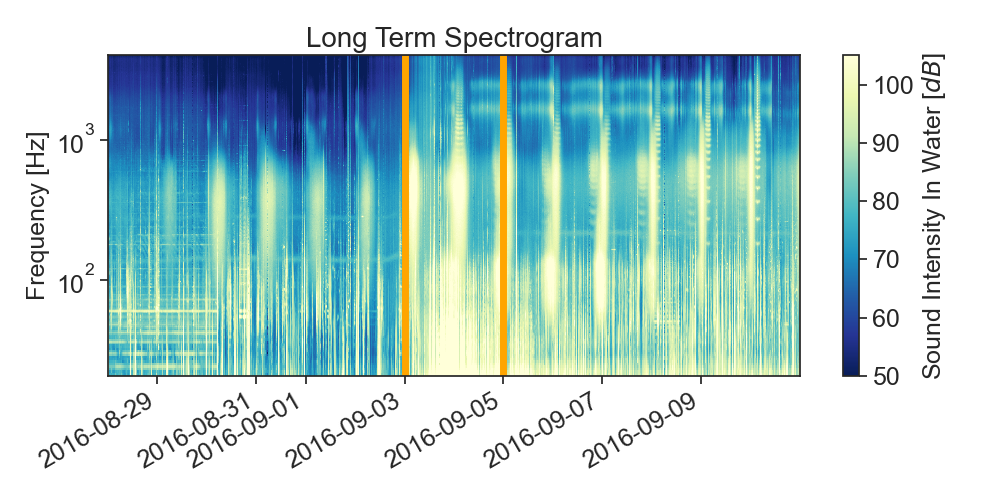

In [88]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 18,          # General font size
    "axes.titlesize": 20,     # Title font size
    "axes.labelsize": 18,     # Axes label font size
    "xtick.labelsize": 18,    # X-axis tick font size
    "ytick.labelsize": 18     # Y-axis tick font size
})

fig, ax = plt.subplots(figsize=(10, 5))
plot_ltsa(ds=sound_ds, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
          time_coord='time', vmin=50, vmax=105)
# Add a line for start and end of the hurricane 
plt.vlines(x=[start_hurricane, end_hurricane], ymin=20, ymax=4000, color='orange', linewidth=5)
plt.show()

outputfile = output_path  + 'SoundCoopPaper-CaseStudy4-2weekLTSA.png'
fig.savefig(outputfile) # save as png

## Compare with environmental data during the hurricane

In [89]:
# https://soundcoop.portal.axds.co/#soundcoop/datasets/BOEM-VA
erddap_dataset = 'gov-ndbc-44014'
sound_dataset = 'BOEM-VA'
min_frequency = 1
max_frequency = 3988

In [90]:
erddap_base_url = 'https://erddap.sensors.ioos.us/erddap'

In [91]:
# Get environmental sensor station lat/lon for use in mapping and querying water temperature climatology data
erddap_metadata_url = f'{erddap_base_url}/info/{erddap_dataset}/index.csv'
env_metadata_df = pd.read_csv(erddap_metadata_url)

env_station_x = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lon_min']['Value'].item()
env_station_y = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lat_min']['Value'].item()

In [92]:
# Manage wind speed units
wind_speed_units_row = env_metadata_df[
    (env_metadata_df['Row Type'] == 'attribute') & 
    (env_metadata_df['Attribute Name'] == 'units') & 
    (env_metadata_df['Variable Name'] == 'wind_speed')
]
wind_speed_units = wind_speed_units_row.iloc[0]['Value']
wind_speed_units

'm.s-1'

In [93]:
wind_speed_to_kts_factors = {
    "m.s-1": 1.94384,
    "mph": 0.86897423357831,
    "kmh": 0.53995555554212126825,
    "ft.s-1": 0.59248243198521155506
}

In [94]:
if wind_speed_units in wind_speed_to_kts_factors:
    print("Success! Units can be converted from", wind_speed_units,'to','kts')
else:
    print("Error! Wind speed cannot be converted from", wind_speed_units,'to','kts')

Success! Units can be converted from m.s-1 to kts


In [95]:
# Grab the same time range covered by the sound data
time_start = np.datetime_as_string(sound_ds.time.min().to_pandas())
time_end = np.datetime_as_string(sound_ds.time.max().to_pandas())

wind_var = 'wind_speed'
swt_var = 'sea_surface_temperature'
wave_var = 'sea_surface_wave_significant_height'
anomaly_var = 'swt_anomaly'
wind_var_kts = 'wind_speed_kts'

erddap_dataset_url = (
    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
    f'?time,{wind_var},{swt_var},{wave_var}&time>={time_start}&time<={time_end}'
)

In [96]:
env_df = pd.read_csv(
    erddap_dataset_url,
    skiprows=[1]  # The second row (index 1) are the column units, which we don't need
)

In [97]:
# Format the time field and set it as the index
env_df['time'] = pd.to_datetime(env_df['time'])
env_df['wind_speed_kts']=env_df['wind_speed'].apply(lambda x : x*wind_speed_to_kts_factors[wind_speed_units])
env_df = env_df.set_index('time').sort_index()

In [98]:
# Save CSV of environmental data
env_df.to_csv(f'env_df_{erddap_dataset}.csv')

## Merge sound and environmental data

In [99]:
# Temporal resolution to which we'll resample the sound and environmental data
# in order to merge them and plot them against each other
temporal_resolution = 'h'

In [100]:
# Convert env_df to an Xarray Dataset so it can be merged with the sound data
env_ds = env_df.to_xarray()
env_ds['time'] = pd.DatetimeIndex(env_ds['time'].values)

In [101]:
# Resample sound and environmental data and merge in to a single Xarray Dataset
ds = xr.merge([
    sound_ds.psd.resample(time=temporal_resolution).median(),
    env_ds.resample(time=temporal_resolution).mean()
])

## Calculate and integrate temperature anomaly data

In [102]:
def get_woa23_temp_at_xy(x, y, month, var='t_mn', depth=0):
    """
    Get 1-degree WOA 2023 temperature values for a given point and month.

    Args:
        x: A longitude value given in decimal degrees
        y: A latitude value given in decimal degrees
        month: The month asn integer from which to extract the value
        var (optional): The temperature variable to use. Defaults to the statistical mean.
        depth (optional): The depth at which to extract the value. Defaults to the surface.
    """
    url = (
        'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
        f'temperature/netcdf/decav/1.00/woa23_decav_t{month:02}_01.nc'
    )
    ds = xr.open_dataset(
        url,
        decode_times=False  # xarray can't handle times defined as "months since ..."
    )

    da = ds.isel(depth=depth)[var]  # Pull out just the variable we're interested in

    # Because nearshore locations are often NaN due to the grid's low resolution
    # we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
    # We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
    # can only interpolate in one dimension.
    da = da.rio.write_crs(4326)
    da = da.rio.interpolate_na(method='nearest')

    # Then we extract the value, also using the nearest neighbor method because the given
    # x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
    val = da.sel(lon=x, lat=y, method='nearest').item()

    return val

In [103]:
# Define the location of our selected ERDDAP dataset
# Override here if needed
x = env_station_x
y = env_station_y

In [104]:
url = (
    'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
    f'temperature/netcdf/decav/1.00/woa23_decav_t07_01.nc'
)
da = xr.open_dataset(
    url,
    decode_times=False  # xarray can't handle times defined as "months since ..."
).isel(depth=0)['t_mn']  # Pull out just the variable we're interested in


In [105]:
da = da.rio.write_crs(4326)
da = da.rio.interpolate_na(method='nearest')

In [106]:
# Assemble a mapping between months and WOA 2023 temperature values
months = list(range(1, 13))
temps = [get_woa23_temp_at_xy(x, y, m) for m in months]
clim_dict = {m: t for m, t in zip(months, temps)}

In [107]:
# Calculate the sea water temperature anomaly by subtracting the monthly WOA 2023 temperature value
# from each measured sea water temperature value and store it as a new variable
ds[anomaly_var] = ds[swt_var] - [clim_dict[m] for m in ds.time.dt.month.values]

In [58]:
# Save NetCDF of merged data
ds.to_netcdf(f'merged_data_{sound_dataset}_{erddap_dataset}.nc')

# Save CSV of merged data
ds.to_dataframe().to_csv(f'merged_data_{sound_dataset}_{erddap_dataset}.csv')

## Plot resampled environmental data

In [149]:
sns.set_theme(style='ticks')

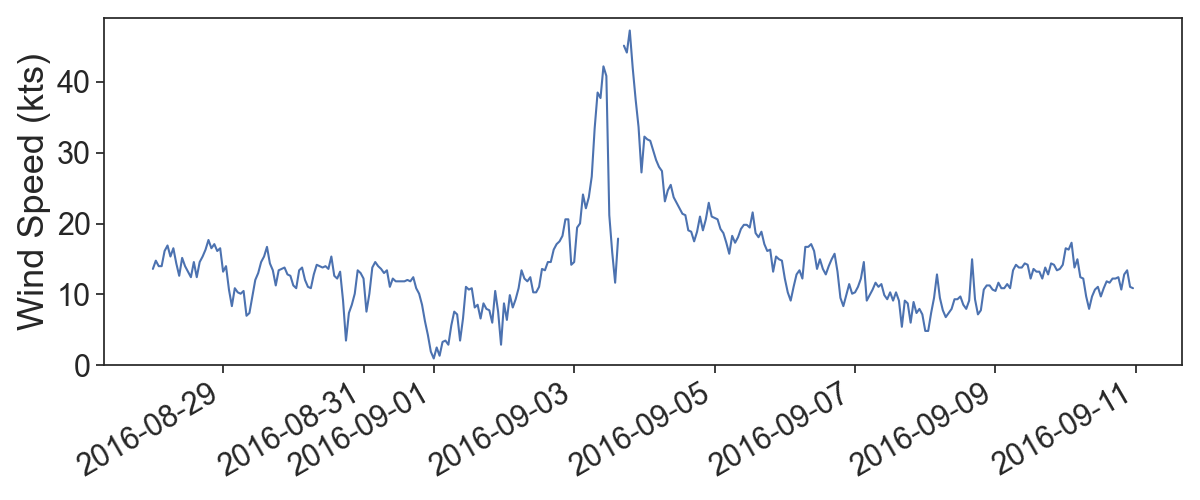

In [150]:
# Plot resampled wind data
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
fig, ax = plt.subplots()

ds[wind_var_kts].plot()

ax.set_xlabel('')
ax.set_ylabel('Wind Speed (kts)', fontsize=26)

# Set face color to white
ax.set_facecolor('white')

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=22)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=22)

ax.set_ylim(0, 49)

plt.show()
fig.savefig(output_path + 'SoundCoopPaper-CaseStudy4-WindSpeed_DuringHermine.png') # save as png

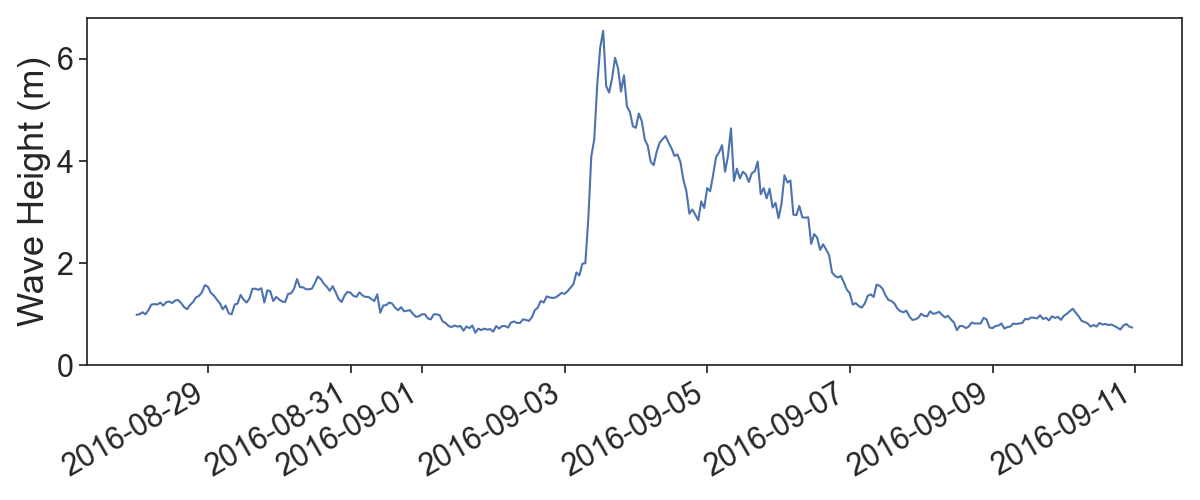

In [151]:
# Plot resampled wave data
fig, ax = plt.subplots()

ds[wave_var].plot()

ax.set_xlabel('')
ax.set_ylabel('Wave Height (m)', fontsize=26)

# Set face color to white
ax.set_facecolor('white')

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=22)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=22)

ax.set_ylim(0, 6.8)

plt.show()
fig.savefig(output_path + 'SoundCoopPaper-CaseStudy4-WaveHeight_DuringHermine.png') # save as png

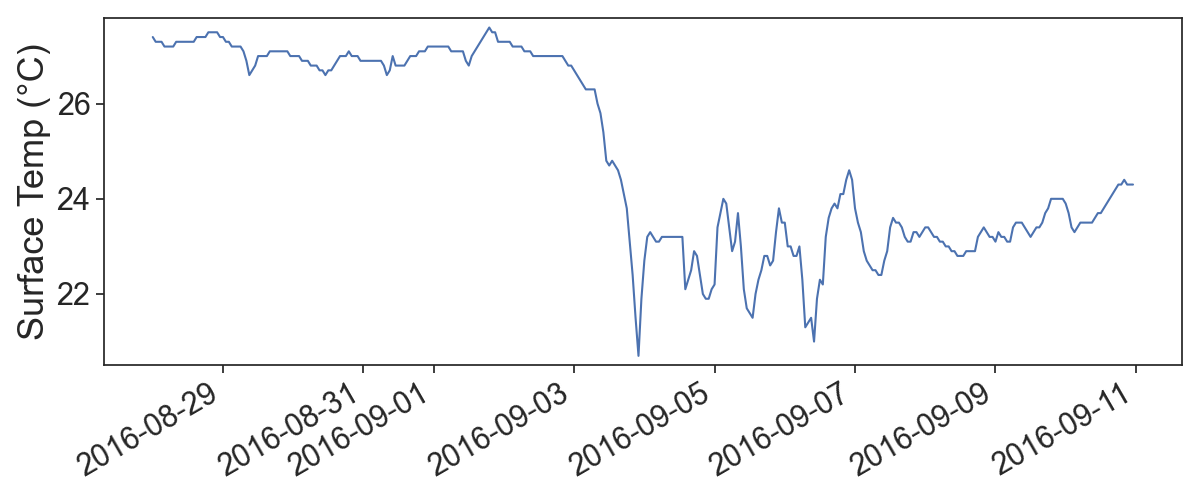

In [152]:
# Plot resampled water temperature data
fig, ax = plt.subplots()

ds[swt_var].plot()

ax.set_xlabel('')
ax.set_ylabel('Surface Temp (°C)', fontsize=26)

# Set face color to white
ax.set_facecolor('white')

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=22)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=22)

ax.set_ylim(20.5, 27.8)

plt.show()
fig.savefig(output_path + 'SoundCoopPaper-CaseStudy4-SurfaceTemperature_DuringHermine.png') # save as png

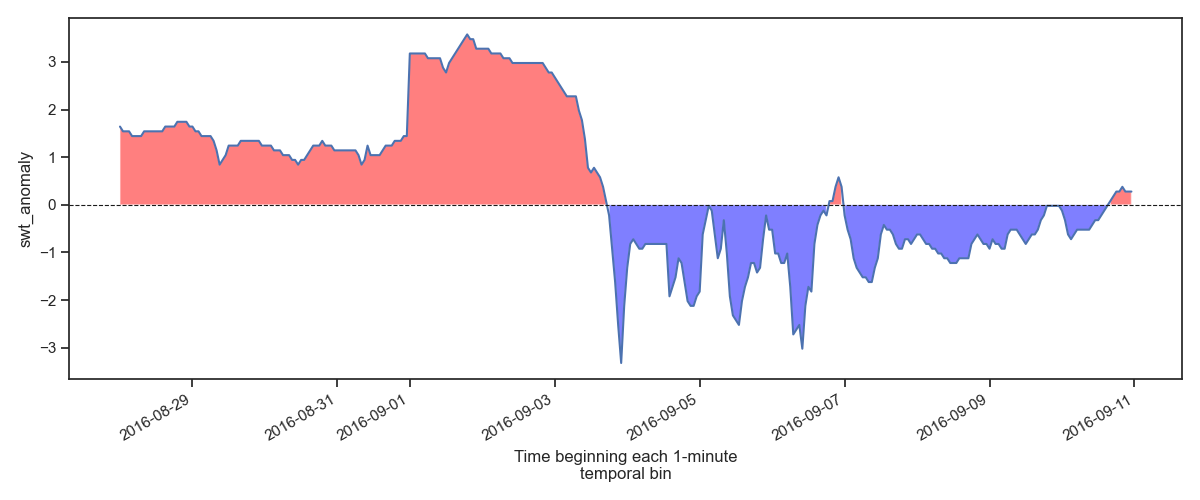

In [153]:
# Plot water temperature anomaly data
ds[anomaly_var].plot(linestyle='-')
plt.fill_between(ds.time.values, ds[anomaly_var], 0, where=(ds[anomaly_var] < 0), facecolor='blue', alpha=0.5)
plt.fill_between(ds.time.values, 0, ds[anomaly_var], where=(ds[anomaly_var] >= 0), facecolor='red', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.show()

## Plot Power Specs

Here we'll plot the power spectrum in different environment conditions DURING the hurricane

We will start defining a function to make this plots, so we don't have to repeat the code

In [144]:
def plot_power_spec(
    ds, 
    conditions=None,
    title=None,
    xlabel='Frequency (Hz)', 
    ylabel='Spectrum levels (dB re 1 $\mu$$Pa^2$/Hz)', # use netcdf attribute
    envelope=True,
    output_path=output_path,
    figureLabel=None
):
    """
    Produces power spec plot given zero or more conditions and labels

    Args:
        ds: An Xarray Dataset consisting of both sound and environmental variables.
        conditions (optional): A single tuple or list of tuples, where each tuple is 
            a condition-label pair, the condition representing a conditional statement to
            be passed to ds.where() and each label representing that condition's legend label.
        title (optional): The plot title.
        xlabel (optional): The X-axis label.
        ylabel (optional): The Y-axis label.
        envelope (optional): Whether or not to plot the 25th to 75th quantile envelope
    """
    plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
    })

   # Create a sequential colormap
    colormap = cm.plasma #cm.PuRd #cm.YlOrRd  
    
    fig, ax = plt.subplots()

    # If no conditions were specified, just plot everything
    if conditions is None:
        # Create a list of colors from the colormap
        colors = colormap(np.linspace(0, 1, 3))
        
        ds.psd.median(dim='time').plot(x='frequency', xscale='log', ax=ax, color=colors[1])

        # Add 25th to 75th quantile envelope
        if envelope:
            plt.fill_between(
                ds.frequency,
                ds.psd.chunk(dict(time=-1)).quantile(0.75, dim='time'),
                ds.psd.chunk(dict(time=-1)).quantile(0.25, dim='time'),
                alpha=0.25, color=colors[1]
            )

    else:
        
        # Create a list of colors from the colormap
        colors = colormap(np.linspace(0, 1, len(conditions)*2))
        counts = 0;
        
        # If conditions is a tuple (i.e. a single condition), wrap it in a list so it's iterable
        if isinstance(conditions, tuple):
            conditions = [conditions]
        
        # Plot each condition in turn
        for c, l in conditions:

            da = ds.where(c, drop=True).psd

            # Only plot if result of where operation has data
            if len(da) > 0:
                
                da.median(dim='time').plot(x='frequency', xscale='log', ax=ax, label=l, color=colors[counts])

                # Add 25th to 75th quantile envelope
                if envelope:
                    plt.fill_between(
                        da.frequency,
                        da.chunk(dict(time=-1)).quantile(0.75, dim='time'),
                        da.chunk(dict(time=-1)).quantile(0.25, dim='time'),
                        alpha=0.25, color=colors[counts]
                    )
            counts=counts+2

        ax.legend()
    
    if title is not None:
        ax.set_title(title, fontsize=26)

    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=14)

    # Set face color to white
    ax.set_facecolor('white')

    # Set the font size of x-tick labels
    ax.tick_params(axis='x', labelsize=22)

    # Set the font size of y-tick labels (optional)
    ax.tick_params(axis='y', labelsize=22)

    ax.set_ylim(50, 120)
    plt.margins(x=0)

    plt.legend(fontsize=20)

    plt.show()

    # Save the plot
    fig.savefig(output_path + figureLabel + '.png') 

In [154]:
def plot_power_spec_anomaly(
    ds, 
    conditions=None,
    title=None,
    xlabel='Frequency (Hz)', 
    ylabel='Spectrum levels (dB re 1 $\mu$$Pa^2$/Hz)', # use netcdf attribute
    envelope=True,
    output_path=output_path,
    figureLabel=None
):
    """
    Produces power spec plot given zero or more conditions and labels

    Args:
        ds: An Xarray Dataset consisting of both sound and environmental variables.
        conditions (optional): A single tuple or list of tuples, where each tuple is 
            a condition-label pair, the condition representing a conditional statement to
            be passed to ds.where() and each label representing that condition's legend label.
        title (optional): The plot title.
        xlabel (optional): The X-axis label.
        ylabel (optional): The Y-axis label.
        envelope (optional): Whether or not to plot the 25th to 75th quantile envelope
    """
    plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
    })

    # Create a sequential colormap
    colormap = cm.coolwarm  
    
    fig, ax = plt.subplots()

    # If no conditions were specified, just plot everything
    if conditions is None:
        # Create a list of colors from the colormap
        colors = colormap(np.linspace(0, 1, 3))
        
        ds.psd.median(dim='time').plot(x='frequency', xscale='log', ax=ax, color=colors[1])

        # Add 25th to 75th quantile envelope
        if envelope:
            plt.fill_between(
                ds.frequency,
                ds.psd.chunk(dict(time=-1)).quantile(0.75, dim='time'),
                ds.psd.chunk(dict(time=-1)).quantile(0.25, dim='time'),
                alpha=0.25, color=colors[1]
            )

    else:
        
        # Create a list of colors from the colormap
        colors = colormap(np.linspace(0, 1, len(conditions)*2))
        counts = 1;
        
        # If conditions is a tuple (i.e. a single condition), wrap it in a list so it's iterable
        if isinstance(conditions, tuple):
            conditions = [conditions]
        
        # Plot each condition in turn
        for c, l in conditions:

            da = ds.where(c, drop=True).psd

            # Only plot if result of where operation has data
            if len(da) > 0:
                
                da.median(dim='time').plot(x='frequency', xscale='log', ax=ax, label=l, color=colors[counts])

                # Add 25th to 75th quantile envelope
                if envelope:
                    plt.fill_between(
                        da.frequency,
                        da.chunk(dict(time=-1)).quantile(0.75, dim='time'),
                        da.chunk(dict(time=-1)).quantile(0.25, dim='time'),
                        alpha=0.25, color=colors[counts]
                    )
            counts=counts+2

        ax.legend()
    
    if title is not None:
        ax.set_title(title, fontsize=26)

    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=14)

    # Set face color to white
    ax.set_facecolor('white')

    # Set the font size of x-tick labels
    ax.tick_params(axis='x', labelsize=22)

    # Set the font size of y-tick labels (optional)
    ax.tick_params(axis='y', labelsize=22)
    
    ax.set_ylim(50, 120)
    plt.margins(x=0)

    plt.legend(fontsize=20)

    plt.show()

    # Save the plot    
    fig.savefig(output_path + figureLabel + '.png') 

We'll select only the data during the hurricane

In [138]:
ds_hurricane = ds.sel(time=slice(start_hurricane, end_hurricane))

And we'll plot the LTSA for ONLY the duration of the hurricane

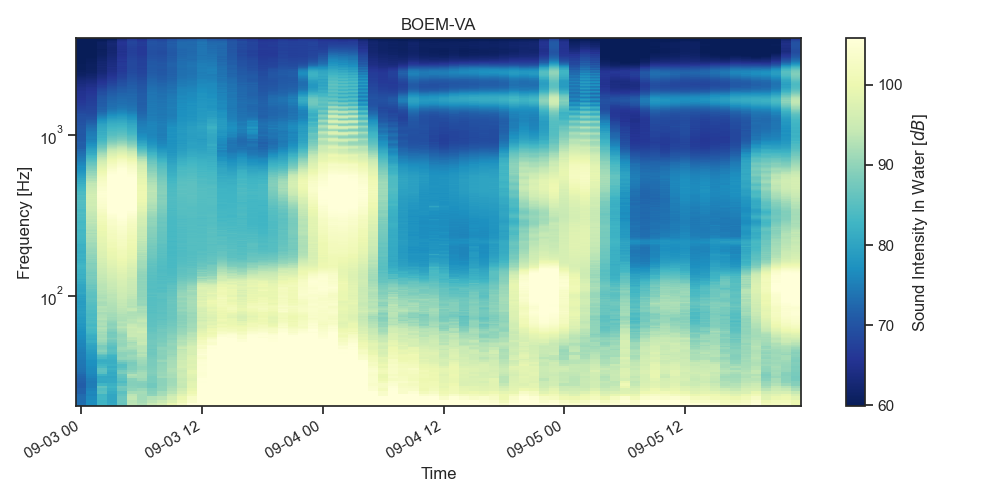

In [139]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_hurricane, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_title(sound_dataset)
plt.show()

fig.savefig(output_path + 'SoundCoopPaper-CaseStudy4-LTSA_DuringHermine.png') 

C:\Users\cwall\AppData\Local\Temp\ipykernel_9292\3764621110.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=26)


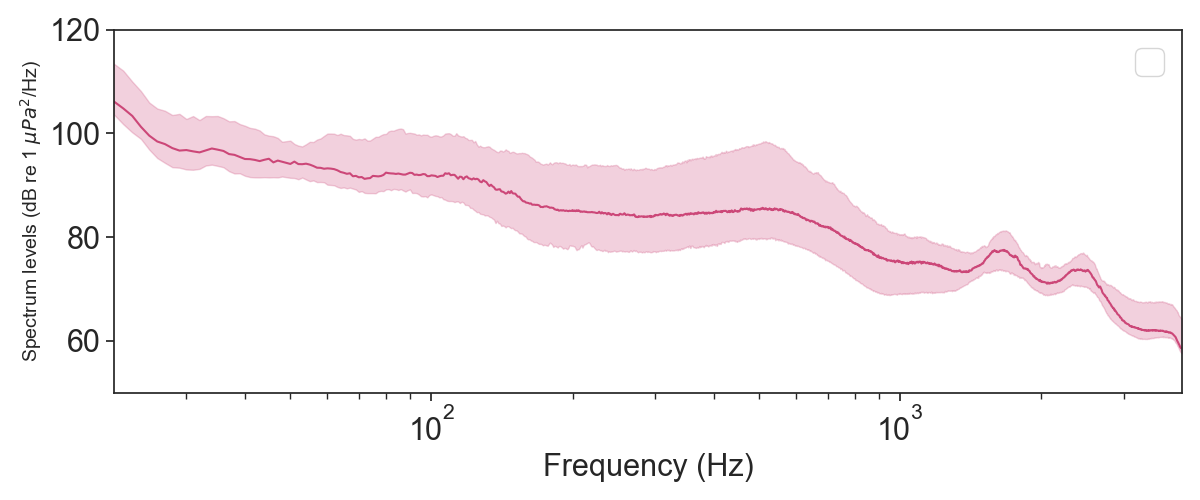

In [140]:
plot_power_spec(ds_hurricane, title='', figureLabel='PSD_during')

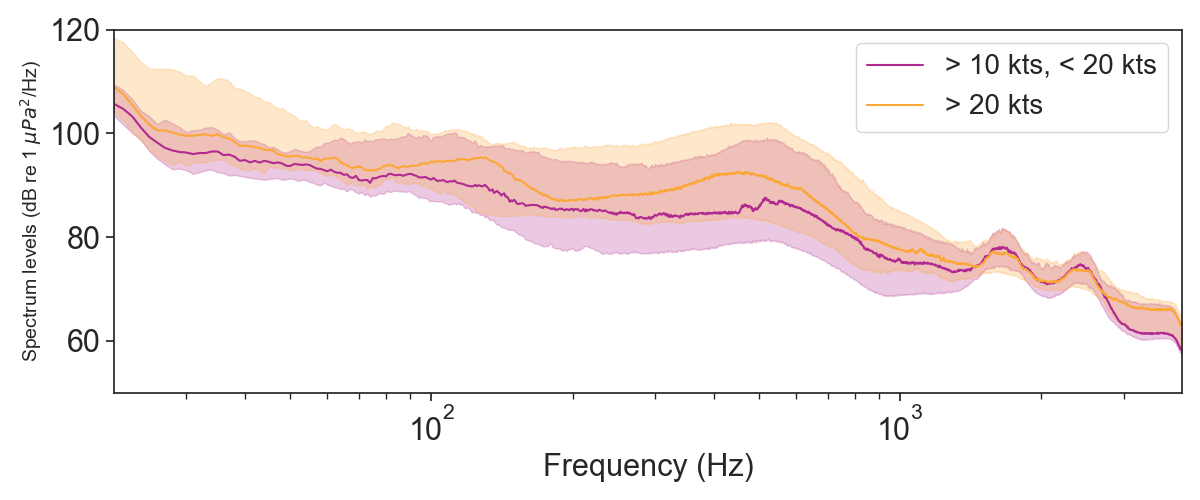

In [155]:
# Plot wind speed intervals
plot_power_spec(
    ds_hurricane,
    conditions=[
        (ds_hurricane[wind_var_kts] <= 10, '< 10 kts'),
        ((ds_hurricane[wind_var_kts] > 10) & (ds_hurricane[wind_var] <= 20), '> 10 kts, < 20 kts'),
        (ds_hurricane[wind_var_kts] > 20, '> 20 kts')
    ],
    figureLabel='SoundCoopPaper-CaseStudy4-windSpeed_DuringHermine',
    title='' #title='Power spec by wind speed intervals'
)

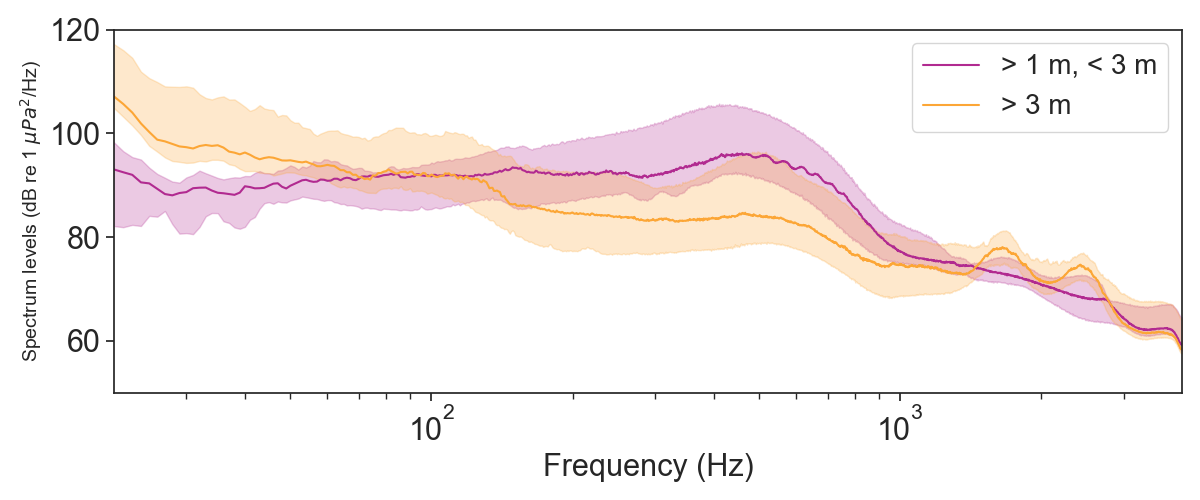

In [156]:
# Plot waves height intervals
plot_power_spec(
    ds_hurricane,
    conditions=[
        (ds_hurricane[wave_var] <= 1, '< 1 m'),
        ((ds_hurricane[wave_var] > 1) & (ds_hurricane[wave_var] <= 3), '> 1 m, < 3 m'),
        (ds_hurricane[wave_var] > 3, '> 3 m')
    ],
    figureLabel='SoundCoopPaper-CaseStudy4-waveHeight_DuringHermine',
    title='' #title='Power spec by wave height intervals'
)

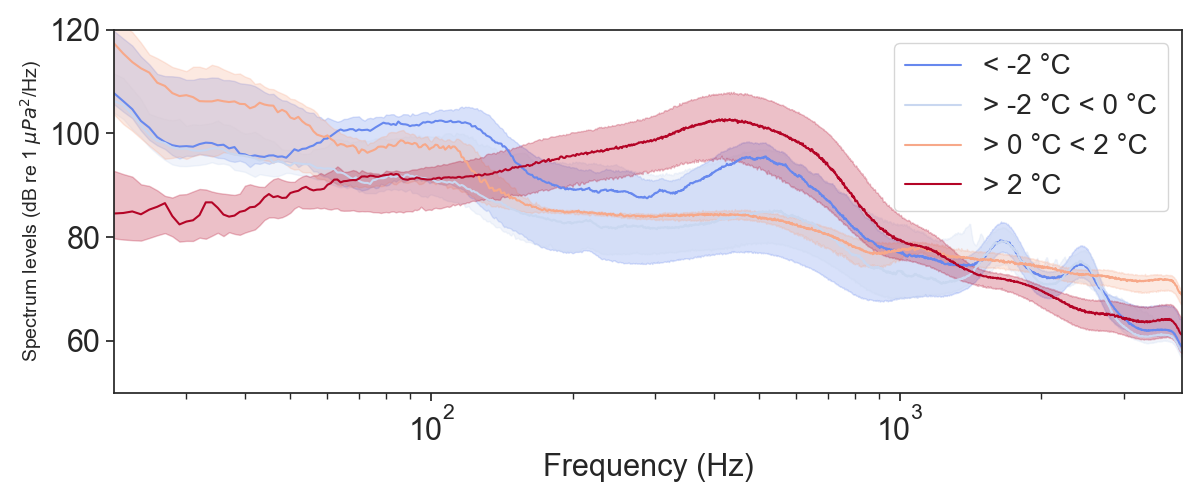

In [148]:
# Plot temperature anomaly intervals

plot_power_spec_anomaly(
    ds_hurricane,
    conditions=[
        (ds_hurricane[anomaly_var] < -2, '< -2 °C'),
        ((ds_hurricane[anomaly_var] < 0) & (ds_hurricane[anomaly_var] >= -2), '> -2 °C < 0 °C'),
        ((ds_hurricane[anomaly_var] >= 0) & (ds_hurricane[anomaly_var] <= 2), '> 0 °C < 2 °C'),
        (ds_hurricane[anomaly_var] > 2, '> 2 °C')
    ],
    figureLabel='SoundCoopPaper-CaseStudy4-tempAnomaly_DuringHermine',
    title='' #'Power spec by temp anomaly'
)